# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import
train_data = pd.read_csv('TitanicTrain.csv')
test_data = pd.read_csv('TitanicTest.csv')
train_data['TrainTest'] = 1
test_data['TrainTest'] = 0
test_data['Survived'] = np.NaN
all_data = pd.concat([train_data, test_data])

# Numeric and categorical separation
num_features = all_data[['Age', 'Pclass', 'SibSp','Parch','Fare']]
cat_features = all_data[['Survived', 'Sex','Ticket','Cabin','Embarked']]

passenger_ids = test_data['PassengerId']

# Data decription

In [3]:
# Global quick view of the train dataset
all_data.info()

print('\n' + '_ ' * 70 + '\n')

all_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  TrainTest    1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,TrainTest
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


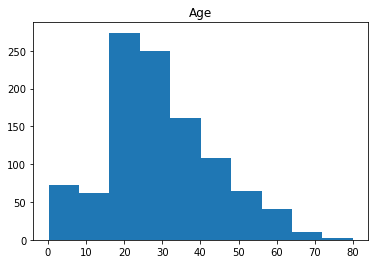

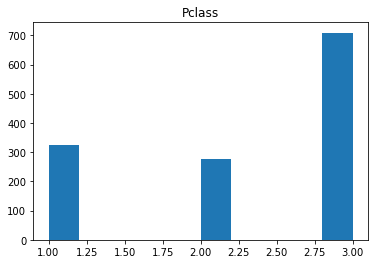

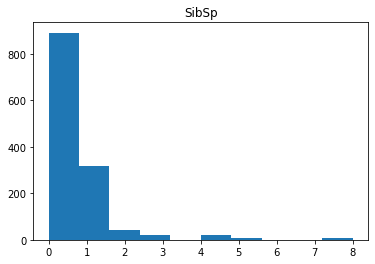

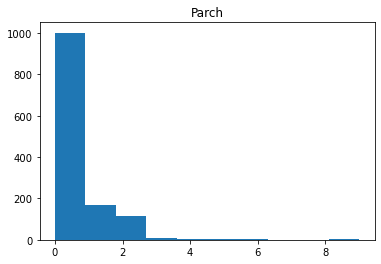

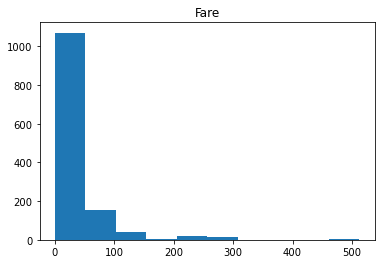

In [4]:
# Numeric features distribution
for col in num_features.columns:
  plt.hist(num_features[col])
  plt.title(col)
  plt.show()

In [5]:
# Numeric features correlation
all_data.drop("TrainTest", axis=1).corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.028814,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.178740,0.160238,0.221539,1.000000


In [6]:
# Mean profile of those who survived and those who didn't
pd.pivot_table(all_data, index='Survived', values=['Age', 'Pclass', 'SibSp','Parch','Fare'])

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0.0,30.626179,22.117887,0.329690,2.531876,0.553734
1.0,28.343690,48.395408,0.464912,1.950292,0.473684


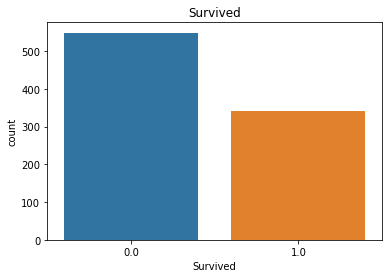

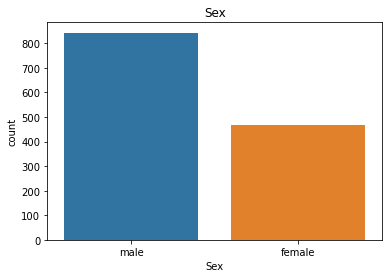

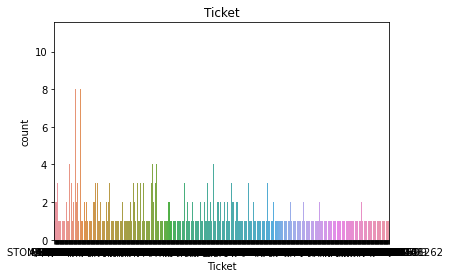

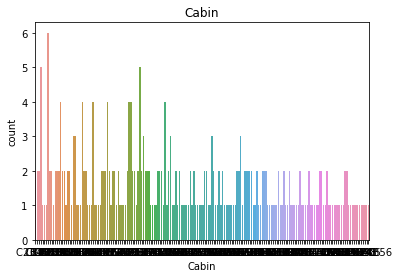

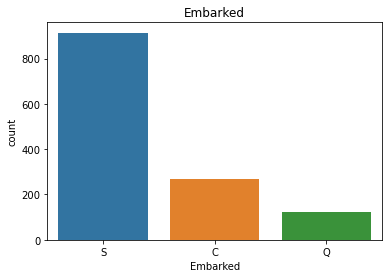

In [7]:
# Categorical features count
for col in cat_features.columns:
    sns.countplot(data=all_data, x=cat_features[col].name).set_title(col)
    plt.show()

# Data engineering

In [8]:
# Impute missing values for the Age feature according to the medians of each "main" categories
medians_values = all_data.groupby(['Sex', 'Pclass']).median()['Age']
female_pclass1_median = medians_values[0]
female_pclass2_median = medians_values[1]
female_pclass3_median = medians_values[2]
male_pclass1_median = medians_values[3]
male_pclass2_median = medians_values[4]
male_pclass3_median = medians_values[5]

temp = all_data.Age.copy()
for i in range(len(temp)):
  if pd.isna(temp.iloc[i]):
    if all_data.Sex.iloc[i] == 'female' and all_data.Pclass.iloc[i] == 1:
      temp.iloc[i] = female_pclass1_median
    elif all_data.Sex.iloc[i] == 'female' and all_data.Pclass.iloc[i] == 2:
      temp.iloc[i] = female_pclass2_median
    elif all_data.Sex.iloc[i] == 'female' and all_data.Pclass.iloc[i] == 3:
      temp.iloc[i] = female_pclass3_median
    elif all_data.Sex.iloc[i] == 'male' and all_data.Pclass.iloc[i] == 1:
      temp.iloc[i] = female_pclass1_median
    elif all_data.Sex.iloc[i] == 'male' and all_data.Pclass.iloc[i] == 2:
      temp.iloc[i] = female_pclass2_median
    elif all_data.Sex.iloc[i] == 'male' and all_data.Pclass.iloc[i] == 3:
      temp.iloc[i] = female_pclass3_median

all_data.Age = temp

In [9]:
# Fill the missing value in Fare with the median of the most common profile : a male with no family aboard
all_data.Fare.fillna(all_data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0], inplace=True)

In [10]:
# Filling the missing values in Embarked with S because the information is present on the web
all_data.Embarked.fillna('S', inplace=True)

In [11]:
# Create bins for Age feature
all_data['AgeBin'] = pd.qcut(all_data['Age'], 4)
all_data.drop('Age', axis=1, inplace=True)

In [12]:
# Create bins for Fare feature
all_data['FareBin'] = pd.qcut(all_data['Fare'], 5)
all_data.drop('Fare', axis=1, inplace=True)

In [13]:
# Replace number of siblings and parents by family size
all_data['FamilySize'] = all_data.SibSp + all_data.Parch + 1
all_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [14]:
# Create a TicketFrequency feature
all_data['TicketFrequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')
all_data.drop('Ticket', axis=1, inplace=True)

In [15]:
# Create a Title feature
all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
all_data.drop('Name', axis=1, inplace=True)

In [16]:
# Create a IsMarried feature
all_data['IsMarried'] = 0
all_data['IsMarried'].loc[all_data['Title'] == 'Mrs'] = 1

In [17]:
# Cabin feature engineering
all_data['Deck'] = all_data.Cabin
all_data.Deck.fillna('M', inplace=True)
all_data.Deck = all_data.Cabin.str.extract(pat='([A-Z])', expand=False)
all_data.Deck.replace({'A':'ABC', 'B':'ABC', 'C':'ABC', 
                    'D':'DE', 'E':'DE', 'F':'FG', 
                    'G':'FD', 'T':'ABC'}, inplace=True)
all_data.drop('Cabin', axis=1, inplace=True)

In [18]:
# Transform Pclass feature as a categorical one
all_data.Pclass = all_data.Pclass.astype(str)

In [19]:
# One-hot encoding
all_data = pd.get_dummies(all_data)

In [20]:
# Remove the IDs
all_data.drop('PassengerId', axis=1, inplace=True)

In [21]:
# Last check
all_data

,Survived,TrainTest,FamilySize,TicketFrequency,IsMarried,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Deck_ABC,Deck_DE,Deck_FD,Deck_FG
0,0.0,1,2,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1.0,1,2,2,1,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,1.0,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2,2,1,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,0.0,1,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,0,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
414,NaN,0,1,3,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
415,NaN,0,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
416,NaN,0,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# Train/Test split
x_train = all_data[all_data.TrainTest == 1].drop(['TrainTest', 'Survived'], axis = 1)
x_test = all_data[all_data.TrainTest == 0].drop(['TrainTest', 'Survived'], axis = 1)

# Labels
y_train = all_data[all_data.TrainTest == 1].Survived

In [23]:
# Scaling
scale = StandardScaler()
x_train = pd.DataFrame(scale.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scale.fit_transform(x_test), columns=x_test.columns)

In [24]:
def cv_performance(cv_scores):
    print('All folds\' scores :')
    print(cv_scores)
    print('\n')
    print('Mean score :')
    print(cv_scores.mean())

# Model selection

In [25]:
# Gaussien Naive Bayes
gnb = GaussianNB()
cv_scores = cross_val_score(gnb, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.64444444 0.68539326 0.65168539 0.70786517 0.75280899 0.76404494
 0.82022472 0.66292135 0.66292135 0.62921348]


Mean score :
0.6981523096129838


In [26]:
# K Neighbors
knn = KNeighborsClassifier()
cv_scores = cross_val_score(knn, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.78888889 0.80898876 0.74157303 0.83146067 0.84269663 0.83146067
 0.84269663 0.7752809  0.86516854 0.82022472]


Mean score :
0.8148439450686642


In [27]:
# Logistic regression
lr = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.8        0.83146067 0.76404494 0.87640449 0.80898876 0.7752809
 0.83146067 0.80898876 0.85393258 0.85393258]


Mean score :
0.8204494382022472


In [28]:
# Decision tree
tr = tree.DecisionTreeClassifier(random_state=1)
cv_scores = cross_val_score(tr, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.74444444 0.80898876 0.70786517 0.84269663 0.85393258 0.82022472
 0.7752809  0.75280899 0.86516854 0.78651685]


Mean score :
0.795792759051186


In [29]:
# Random forest
rf = RandomForestClassifier(criterion='entropy',
                                           bootstrap=True,
                                           n_estimators=400,
                                           max_depth=5,
                                           min_samples_split=2,
                                           min_samples_leaf=3,
                                           max_features='auto',
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)
cv_scores = cross_val_score(rf, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.82222222 0.88764045 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.86516854 0.84269663]


Mean score :
0.8316604244694131


In [30]:
# Support Vector Classification
svc = SVC(probability=True)
cv_scores = cross_val_score(svc, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.78888889 0.88764045 0.75280899 0.86516854 0.83146067 0.82022472
 0.84269663 0.7752809  0.87640449 0.85393258]


Mean score :
0.8294506866416977


In [31]:
# Voting 
voting_clf = VotingClassifier(estimators=[('lr', lr),('knn', knn),('rf', rf),('gnb', gnb),('svc', svc)], voting='soft')
cv_scores = cross_val_score(voting_clf, x_train, y_train, cv=10, n_jobs=-1)
cv_performance(cv_scores)

All folds' scores :
[0.82222222 0.83146067 0.73033708 0.8988764  0.85393258 0.80898876
 0.84269663 0.76404494 0.85393258 0.83146067]


Mean score :
0.8237952559300874


# Model tuning

In [25]:
# Performance reporting
def clf_performance(classifier, model_name):
    print('\n' + '_ ' * 70 + '\n')
    print(model_name)
    print('Best Score:' + str(classifier.best_score_))
    print('Best Parameters:' + str(classifier.best_params_))

In [33]:
# Logistic regression
lr = LogisticRegression()
param_grid = {'max_iter' : [1000, 2000, 3000, 5000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-8, 8, 10),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
clf_lr = clf_lr.fit(x_train, y_train)
clf_performance(clf_lr,'Logistic Regression')

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:   13.6s



_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Logistic Regression
Best Score:0.833932584269663
Best Parameters:{'C': 0.12915496650148828, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   15.5s finished


In [34]:
# K Neighbors
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}

clf_knn = GridSearchCV(knn, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
clf_knn = clf_knn.fit(x_train, y_train)
clf_performance(clf_knn,'KNN')

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s



_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

KNN
Best Score:0.8283021223470662
Best Parameters:{'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 465 out of 480 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.3s finished


In [ ]:
# Support Vector Classification
svc = SVC(probability = True)
param_grid = {'kernel': ['rbf', 'linear', 'poly'],
              'gamma': [.1,.5,1,2,5,10],
              'C': [.1, 1, 10, 100, 1000],
              'degree': [2,3,4,5]}

clf_svc = GridSearchCV(svc, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
clf_svc = clf_svc.fit(x_train, y_train)
clf_performance(clf_svc,'SVC')

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min


In [26]:
# Random forest
rf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [400, 450, 500, 550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
clf_rf = clf_rf.fit(x_train, y_train)
clf_performance(clf_rf,'Random Forest')

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 14.0min finished



_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Random Forest
Best Score:0.8395255930087391
Best Parameters:{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}


# Making predictions

In [27]:
def CSV_File_Build(predictions, file_name):
  csv_file = pd.DataFrame({'PassengerId': passenger_ids,'Survived': predictions})
  csv_file.to_csv(file_name, index=False)

In [28]:
# Logistic regression
modelLR = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=0.13)
modelLR.fit(x_train, y_train)
predictionsLR = modelLR.predict(x_test)
predictionsLR = predictionsLR.astype(int)
CSV_File_Build(predictionsLR,'predictionsLR.csv')

In [29]:
# K Neighbors
modelKNN = KNeighborsClassifier(algorithm='auto', n_neighbors=7, p=1, weights='uniform')
modelKNN.fit(x_train, y_train)
predictionsKNN = modelKNN.predict(x_test)
predictionsKNN = predictionsKNN.astype(int)
CSV_File_Build(predictionsKNN,'predictionsKNN.csv')

In [30]:
# Support Vector Classification
modelSVC = SVC(probability = True, C=0.1, kernel='linear')
modelSVC.fit(x_train, y_train)
predictionsSVC = modelSVC.predict(x_test)
predictionsSVC = predictionsSVC.astype(int)
CSV_File_Build(predictionsSVC,'predictionsSVC.csv')

In [31]:
# Random forest
modelRF = RandomForestClassifier(criterion='entropy',
                                           bootstrap=True,
                                           n_estimators=400,
                                           max_depth=5,
                                           min_samples_split=2,
                                           min_samples_leaf=3,
                                           max_features='auto',
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)
modelRF.fit(x_train, y_train)
predictionsRF = modelRF.predict(x_test)
predictionsRF = predictionsRF.astype(int)
CSV_File_Build(predictionsRF,'predictionsRF.csv')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.0s finished
